## PSL: Smoothing Splines

### Load Libraries
We'll utilize the `csaps` package in Python for fitting the smoothing spline. You might need to install it first. https://pypi.org/project/csaps/

Cubic spline approximation (smoothing):

csaps is a Python package for univariate, multivariate and n-dimensional grid data approximation using cubic smoothing splines. The package can be useful in practical engineering tasks for data approximation and smoothing.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import seaborn as sns

from scipy.interpolate import splev
from scipy.optimize import minimize_scalar

import matplotlib as mpl
import matplotlib.pyplot as plt

from csaps import csaps

### A Simulated Example

This is a simulated example from ESL Chapter 5.5.2. The true function is

$$
f(x) = \frac{\sin(12(x + 0.2))}{x + 0.2}, \quad x \in [0, 1].
$$

In [2]:
def f(x):
    return np.sin(12 * (x + 0.2)) / (x + 0.2)


np.random.seed(1234)
n = 30
err = 1
x = np.sort(np.random.uniform(size=n))
y = f(x) + np.random.normal(0, err, n)
fx = np.arange(1, 51, 1)/50
fy = f(fx)

A graphical representation shows the true function as a grey curve, with observed data points shown as red dots.



Text(0, 0.5, 'y')

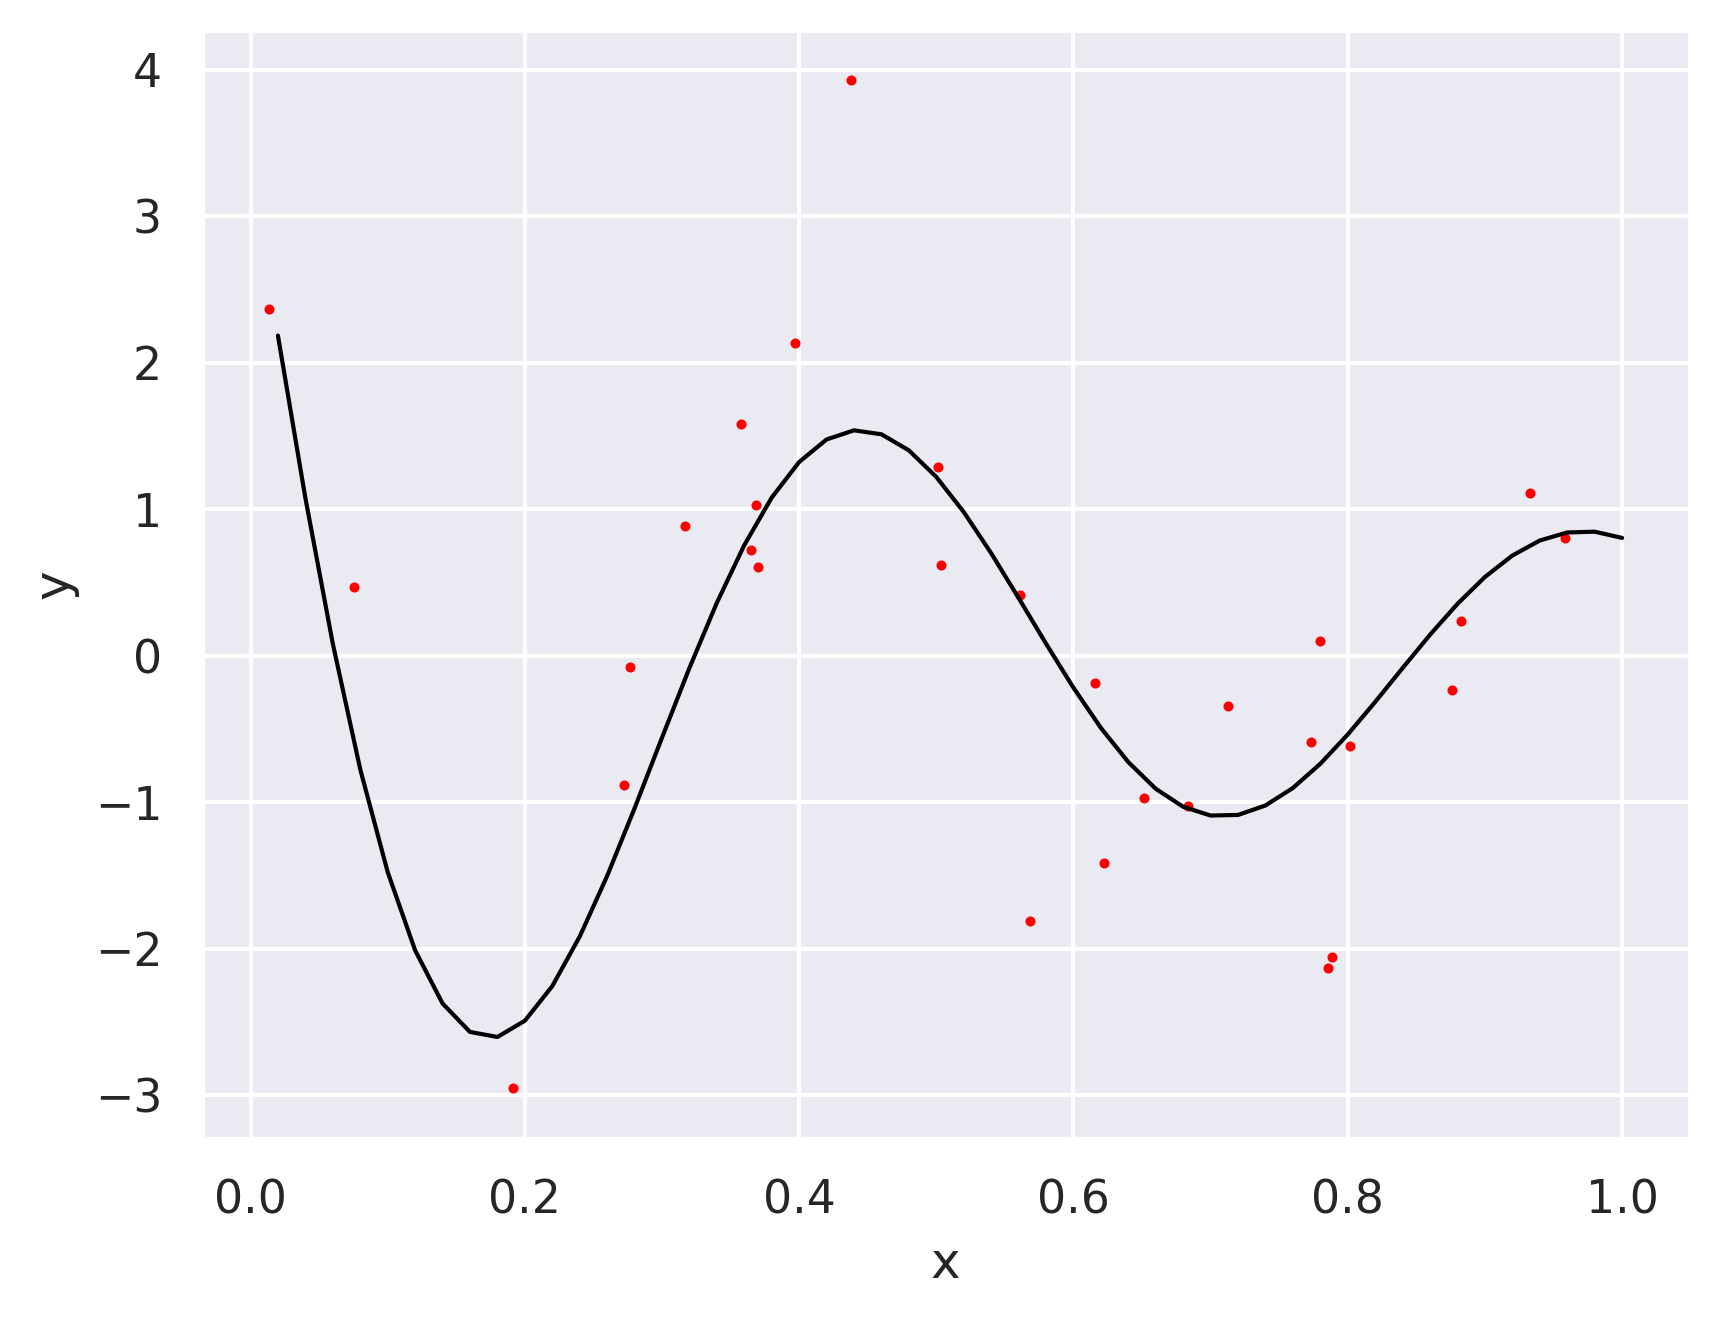

In [3]:
sns.set()
mpl.rcParams['figure.dpi'] = 300
plt.scatter(x, y, color="red", s=2)
plt.plot(fx, fy, color="black", linewidth=1)
plt.xlabel("x")
plt.ylabel("y")

### Fit a Smoothing Spline Model

Smoothing splines are implemented by the Python package `csaps`. However, it solves a slightly different problem than equation (5.9) in ESL

$$
L(f, \lambda) = \sum_{i=1}^{N} (y_i - f(x_i))^2 + \lambda \int \left( f''(t) \right)^2 dt \quad \text{(ESL Formulation)} \tag{1}
$$

$$
L'(f, p) = p \sum_{i=1}^{N} (y_i - f(x_i))^2 + (1 - p) \int \left( f''(t) \right)^2 dt \quad \text{(CSAPS Formulation)} \tag{2}
$$

Given a λ value in the ESL formulation, the equivalent `p` value in the CSAPS formulation is $ p = 1 / (1+\lambda) $.

The function `csaps` takes in several arguments.

- The first two arguments are the training x-values and the training y-values.
- The third argument are the test x-values.
- The fourth argument is the smoothness parameter p.
- There is an optional argument axis when we want to fit models over different sets of training y-values.


First, we will define a function that fits a model parameterized by λ instead of p.

In [4]:
def smooth(x, y, fx, lam, axis=-1):
    return csaps(x, y, fx, smooth=1/(lam + 1), axis=-1)

Given a $\lambda$ value, the degrees of freedom are given by $\text{df} = \text{trace}(\mathbf{S}_\lambda)$. Next, we will define a function that fits a model parameterized by $\text{df}$ instead of $\lambda$. Given a $\text{df}$ value, to find the corresponding $\lambda$ value, we will simply numerically find the minimum of $\ell(\lambda) = (\text{trace}(\mathbf{S}_\lambda) - \text{df})^2$.

The `S_lam` function uses a clever way to "reverse engineer" the smoother matrix $\mathbf{S}_\lambda$ from a smoothing spline when using the `smooth` function. By feeding in specific $\mathbf{y}$ vectors that have a single "1" and otherwise consist of "0"s, you're effectively pulling out each column of $\mathbf{S}_\lambda$ as the prediction of the spline. At the end, to ensure that the matrix is symmetric (which it should be by the nature of the smoother matrix), we average it with its transpose.

It's important to note that this approach works because the smoother matrix is determined by $\mathbf{x}$ alone, and not influenced by $\mathbf{y}$.

In [5]:
def S_lam(x, lam):
    n = len(x)
    Y = np.identity(n)
    A = smooth(x, Y, x, lam, axis=0)
    return (A + A.T)/2


def df_to_lam(x, df):
    def g(lam):
        return (S_lam(x, lam).trace() - df)**2
    return minimize_scalar(g, bounds=(0, 10), options={'xatol': 1e-10}).x


def smooth_df(x, y, fx, df, axis=-1):
    return smooth(x, y, fx, df_to_lam(x, df), axis)

We fit a smoothing spline model with various dfs. A lower `df` leads to a more penalized function which appears flatter since roughness is more penalized. This corresponds to a higher lambda value. As df increases, the fitted spline becomes more flexible or "wiggly".

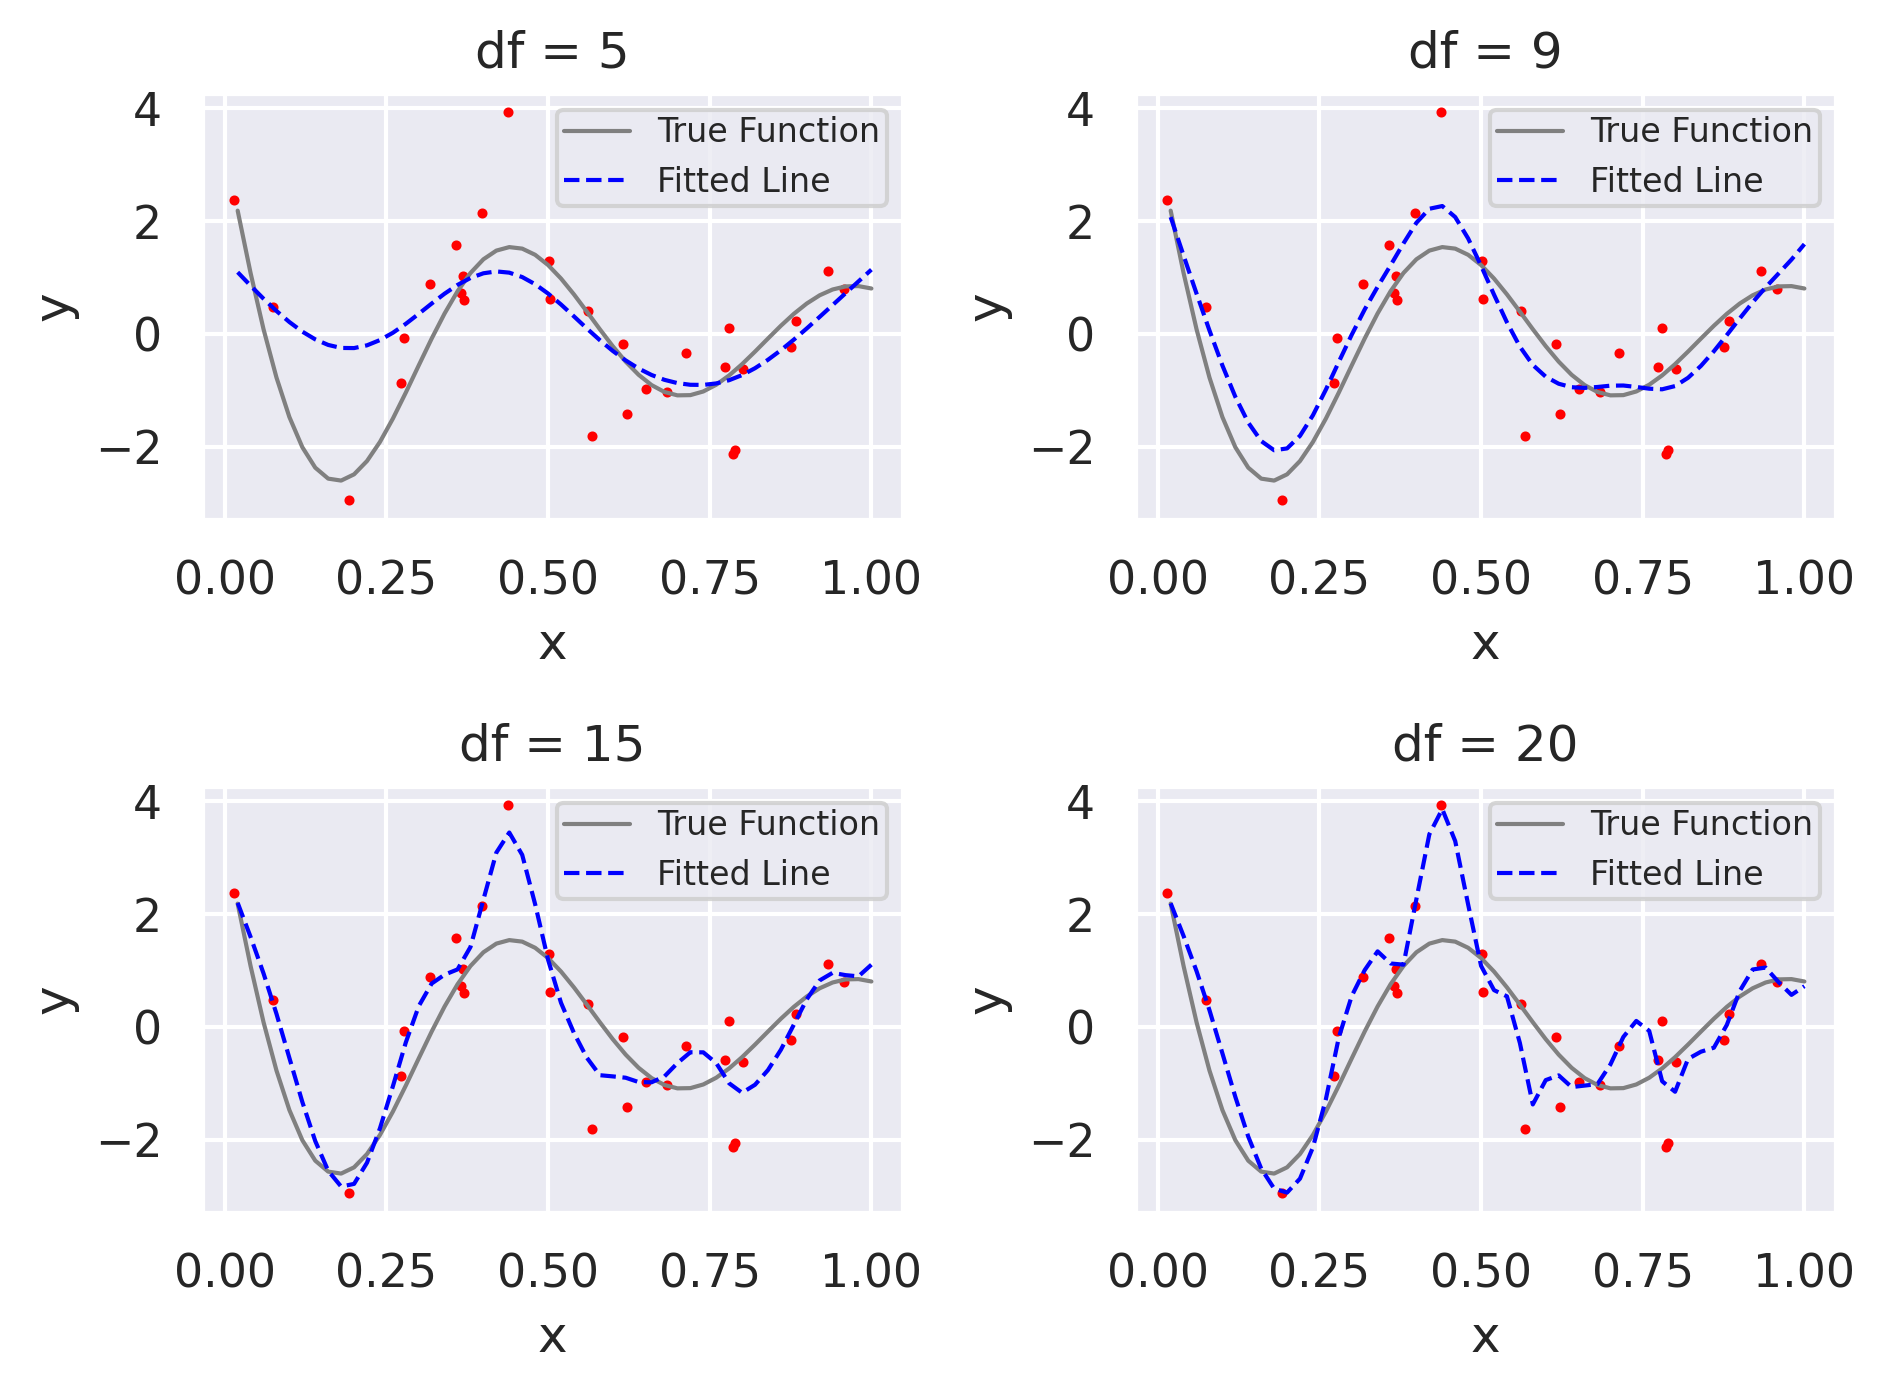

In [6]:
dfs = [5, 9, 15, 20]
fig = plt.figure()
for i in range(len(dfs)):
    plt.subplot(2, 2, i+1)
    plt.scatter(x, y, color="red", s=2)
    plt.plot(fx, fy, color="gray", linewidth=1, label="True Function")
    plt.plot(fx, smooth_df(x, y, fx, dfs[i]), color="blue",
             linestyle="dashed", linewidth=1, label="Fitted Line")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("df = " + str(dfs[i]))
    plt.legend(borderpad=0.2, prop={'size': 8})
fig.tight_layout()

# DR Basis Functions

The DR (Demmler & Reinsch) basis functions are derived from the eigenvectors of the smoother matrix $\mathbf{S}_\lambda$.

We obtain two smoother matrices:

- An n-by-n smoother matrix for df equal to four `S4`
- An n-by-n smoother matrix for df equal to four `S9`

Next we will perform an eigen-decomposition on these two matrices.

The eigen-vectors of the smoother matrix remain consistent regardless of the $\lambda$ value. Consequently, the eigenvectors derived from both `S4` and `S9` are identical, with the exception of possible sign differences. This leads us to the visual representation of the DR (Demmler & Reinsch) basis functions.

These functions are systematically ordered based on increasing eigenvalues. The initial two values, $d_1$ and $d_2$, are zero. This implies that they correspond to linear functions, which we intentionally do not penalize. As eigenvalues increase, the affiliated basis functions exhibit more oscillations or 'wiggles.'

Recall that the shrinkage factor is determined by $1/(1 + \lambda d_i)$. As $d_i$ grows, this factor diminishes, leading to increased shrinkage. This is intuitive because larger $d_i$ values signify more oscillatory basis functions. To mitigate the roughness penalty, it's logical to enforce more stringent shrinkage on coefficients tied to these oscillatory functions.

In [7]:
def S_df(x, df):
    return S_lam(x, df_to_lam(x,  df))

In [8]:
S4 = S_df(fx, 4)
S9 = S_df(fx, 9)

# use eigh instead of eig for more accurate results
val4, vec4 = np.linalg.eigh(S4)
val9, vec9 = np.linalg.eigh(S9)


rev_ord = np.arange(49, -1, -1)  # sort descending instead of ascending
val4, vec4 = val4[rev_ord], vec4[:, rev_ord]
val9, vec9 = val9[rev_ord], vec9[:, rev_ord]

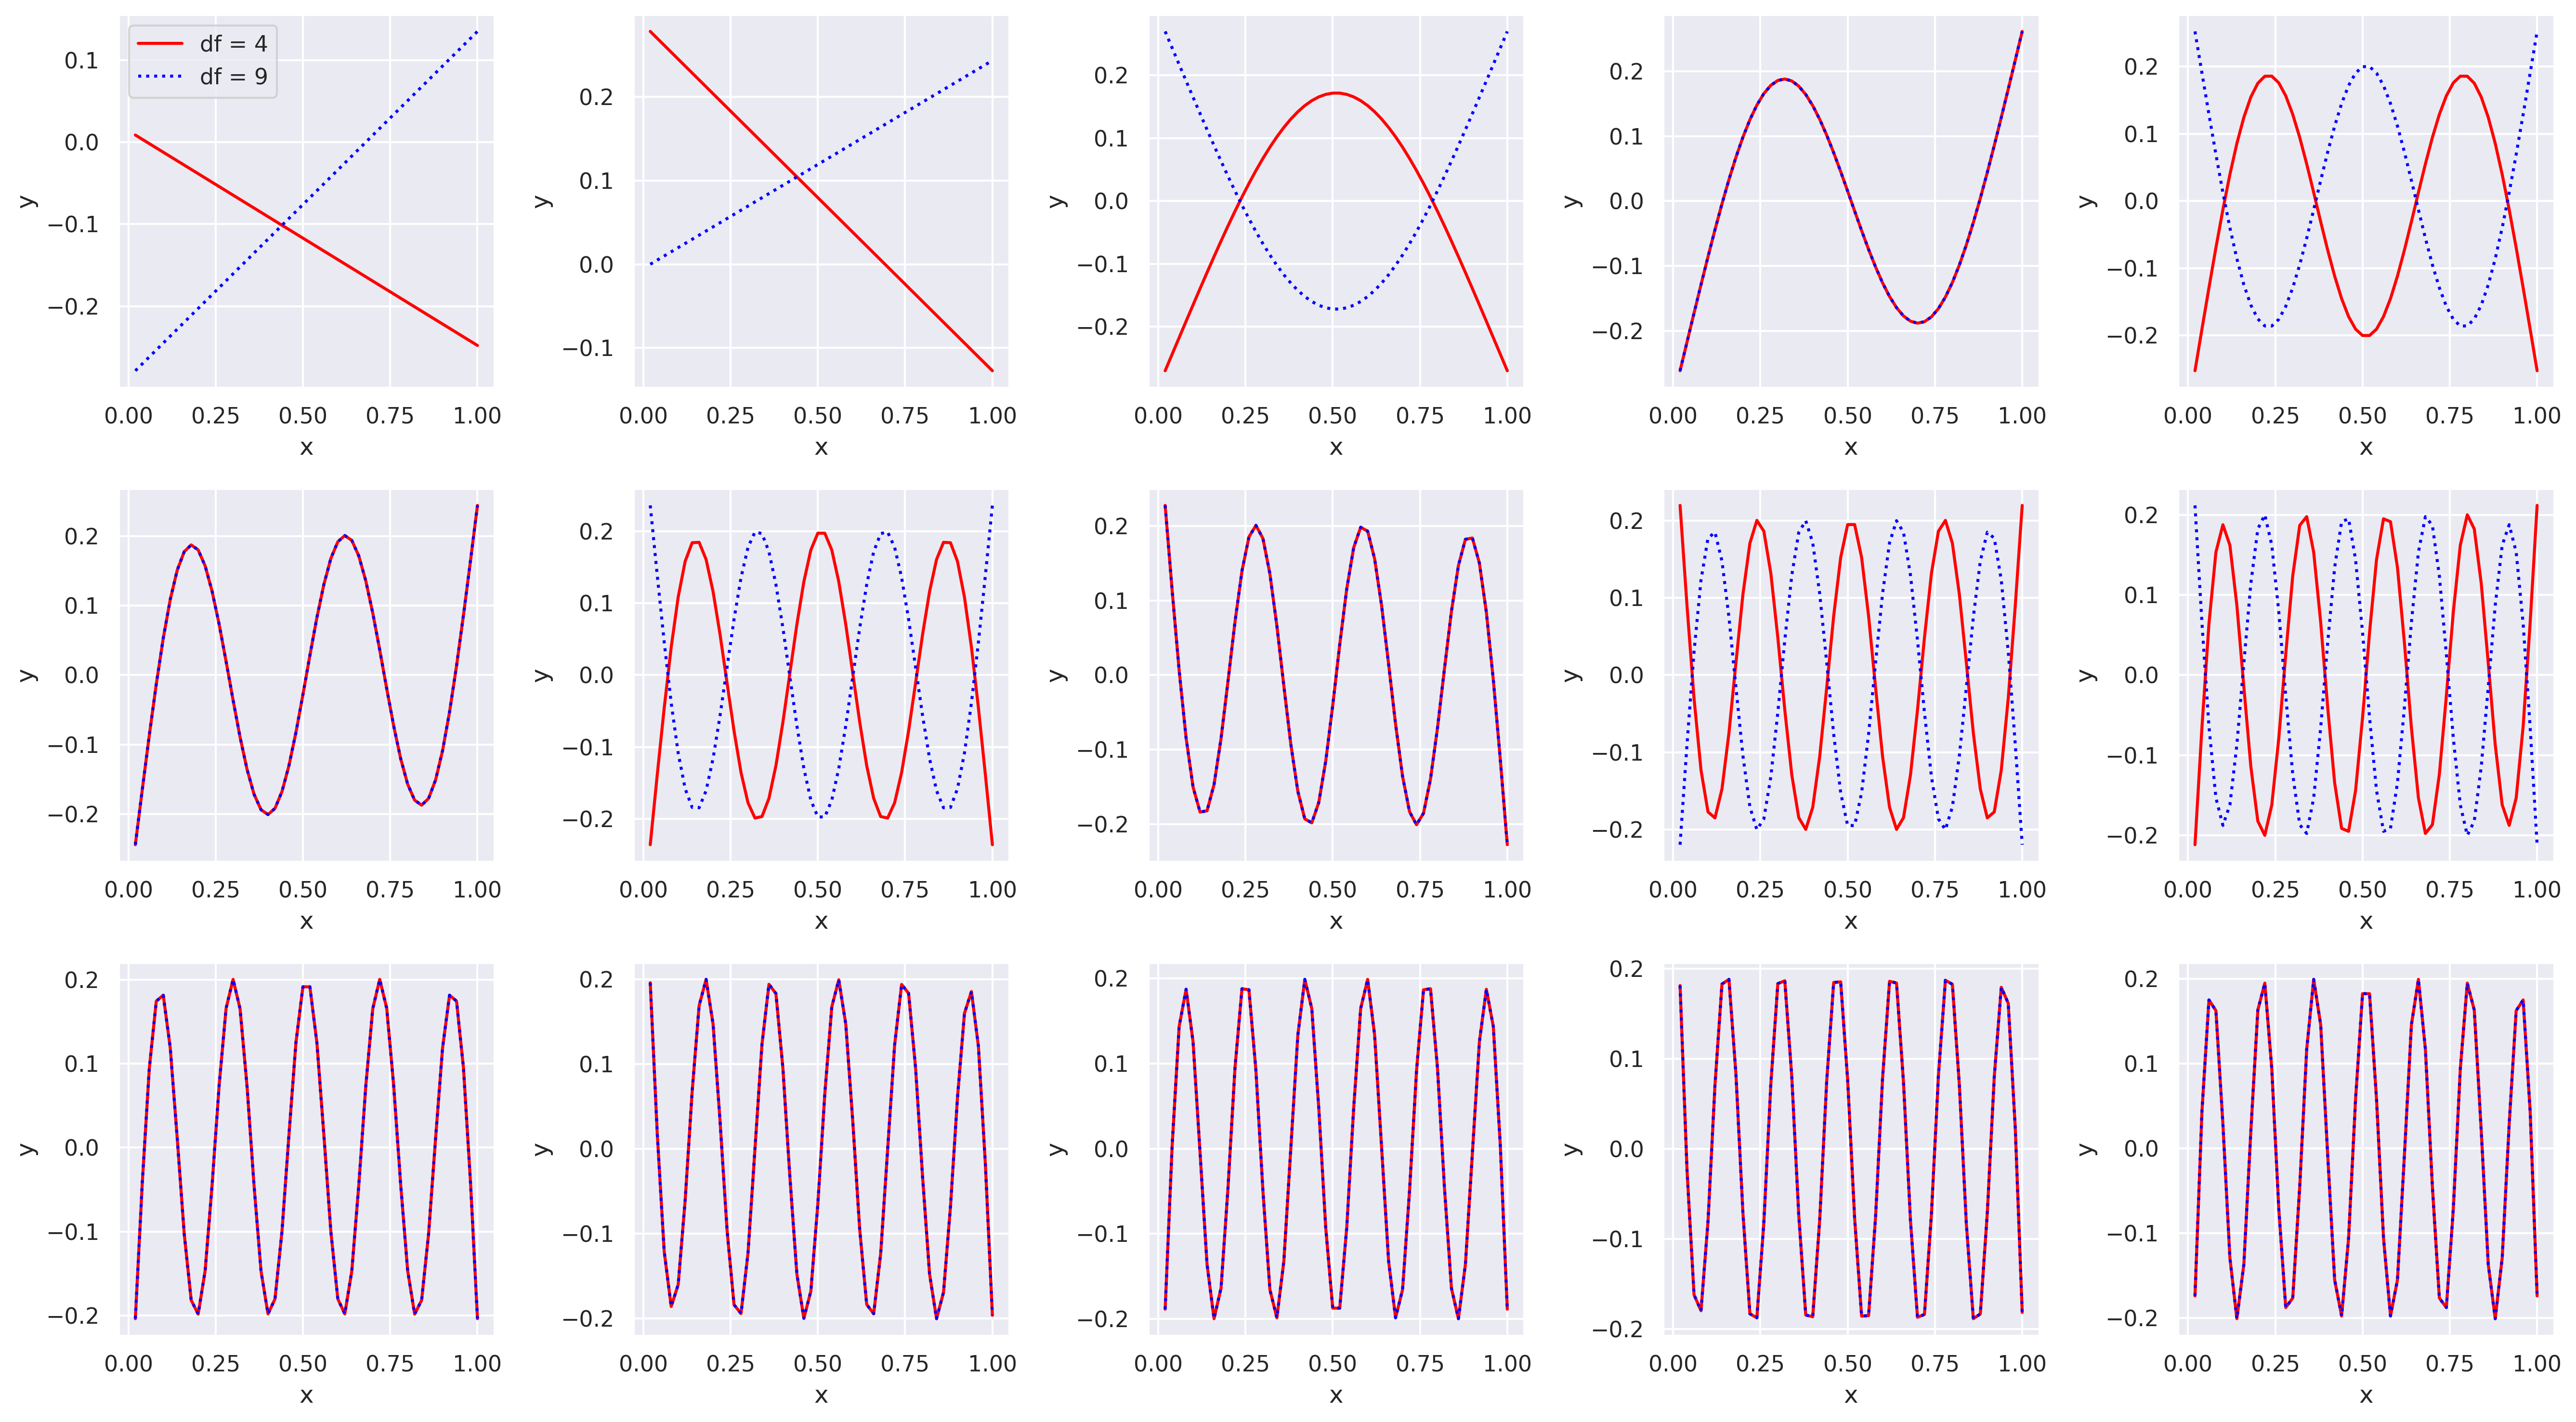

In [9]:
fig = plt.figure(figsize=(18, 10))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.plot(fx, vec4[:, i], color="red", label="df = 4")
    plt.plot(fx, vec9[:, i], color="blue", linestyle="dotted", label="df = 9")
    plt.xlabel("x")
    plt.ylabel("y")
    if i == 0:
        plt.legend()
fig.tight_layout()

Next, we plot the eigenvalues. Note that the first two eigenvalues are always 1.



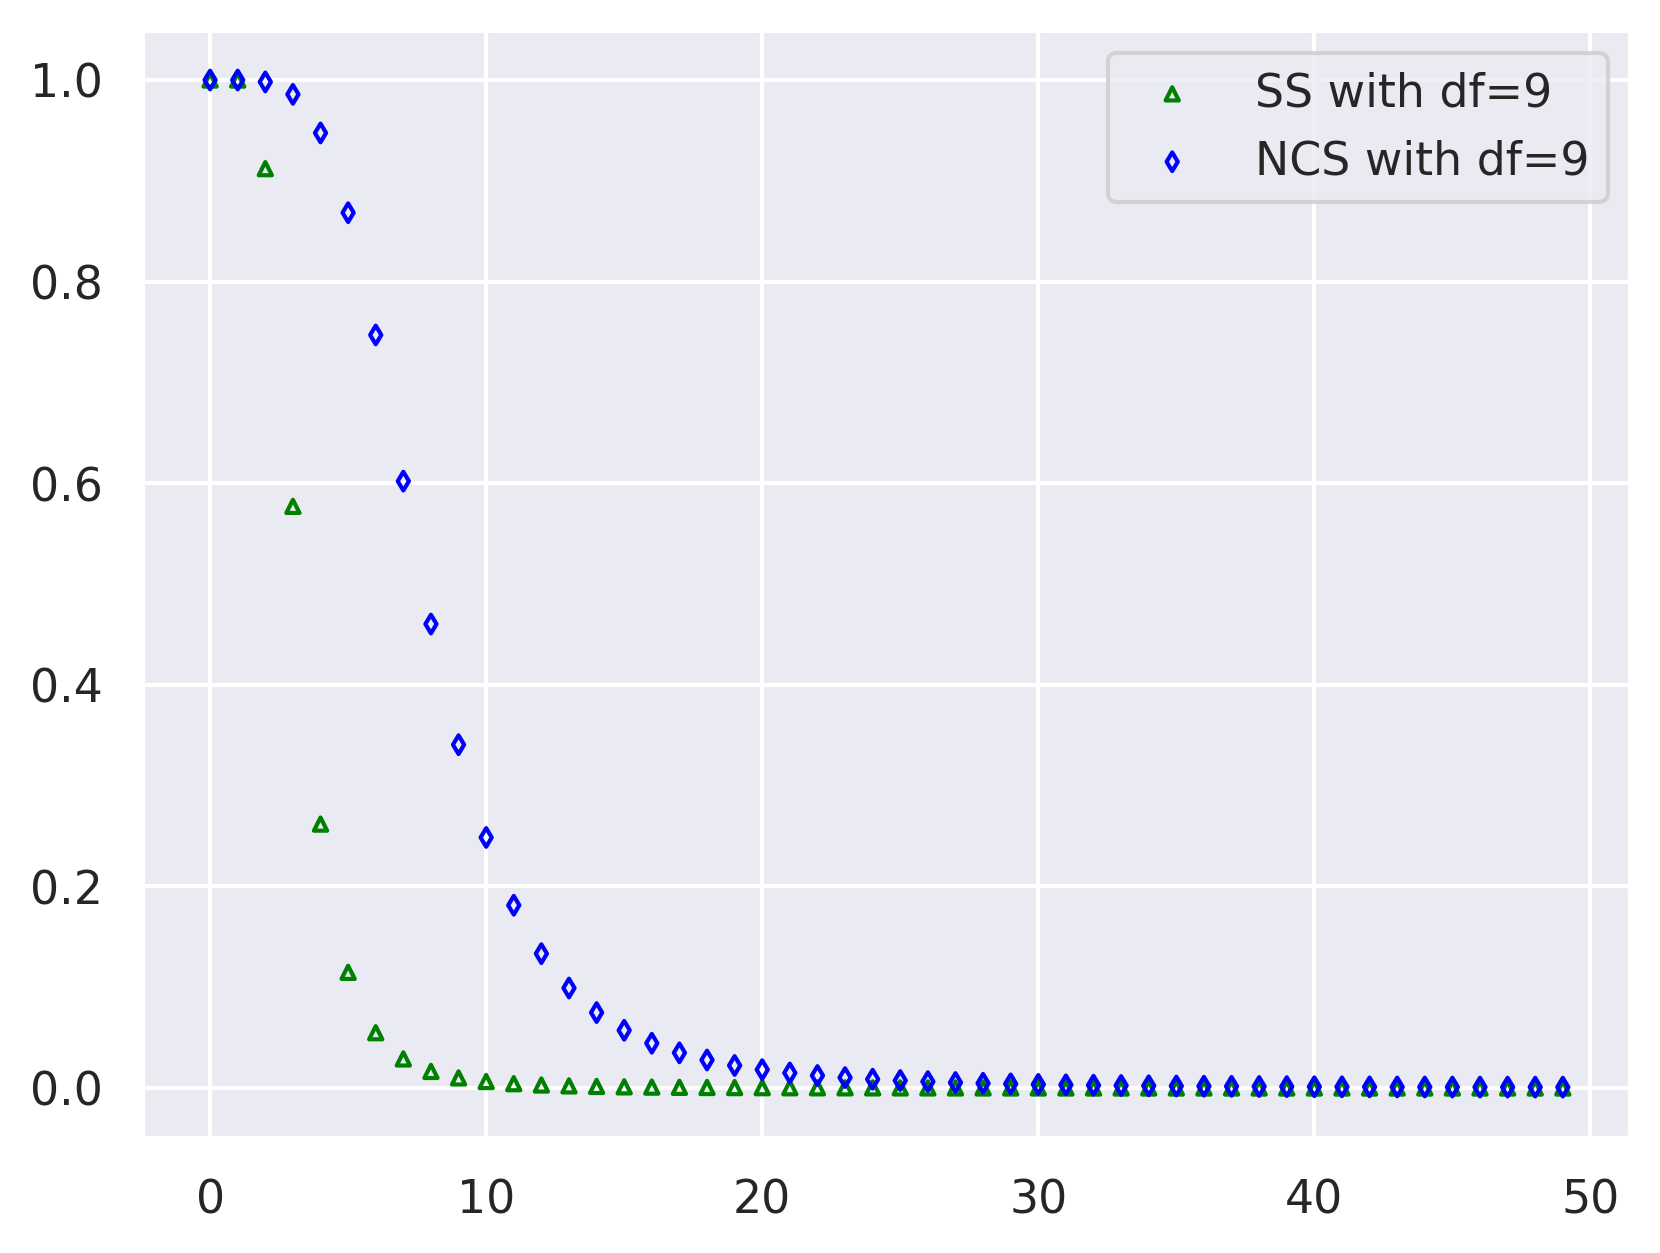

In [10]:
plt.scatter(np.arange(50), val4, s=10, marker='^', color="green",
            facecolors='none', label="SS with df=9")
plt.scatter(np.arange(50), val9, s=10, marker='d', color="blue",
            facecolors='none', label="NCS with df=9")
plt.legend()

Check for the effective degree of freedom.



In [11]:
print(S4.trace())
print(S9.trace())

3.999999999514372
8.999999969979706


### Choice of Lambda
Employ LOO-CV and GCV to select df. Just as with Ridge Regression, smoothing splines can possess fractional dfs.

In [12]:
def gcv(x, y, df):
    fit = smooth_df(x, y, x, df)
    return (((y - fit) ** 2) / ((1 - df/n) ** 2)).mean()


def lcv(x, y, df):
    fit = smooth_df(x, y, x, df)
    lev = np.diag(S_df(x, df=df))
    return (((y - fit) ** 2) / ((1 - lev) ** 2)).mean()

Text(0, 0.5, 'CV Score')

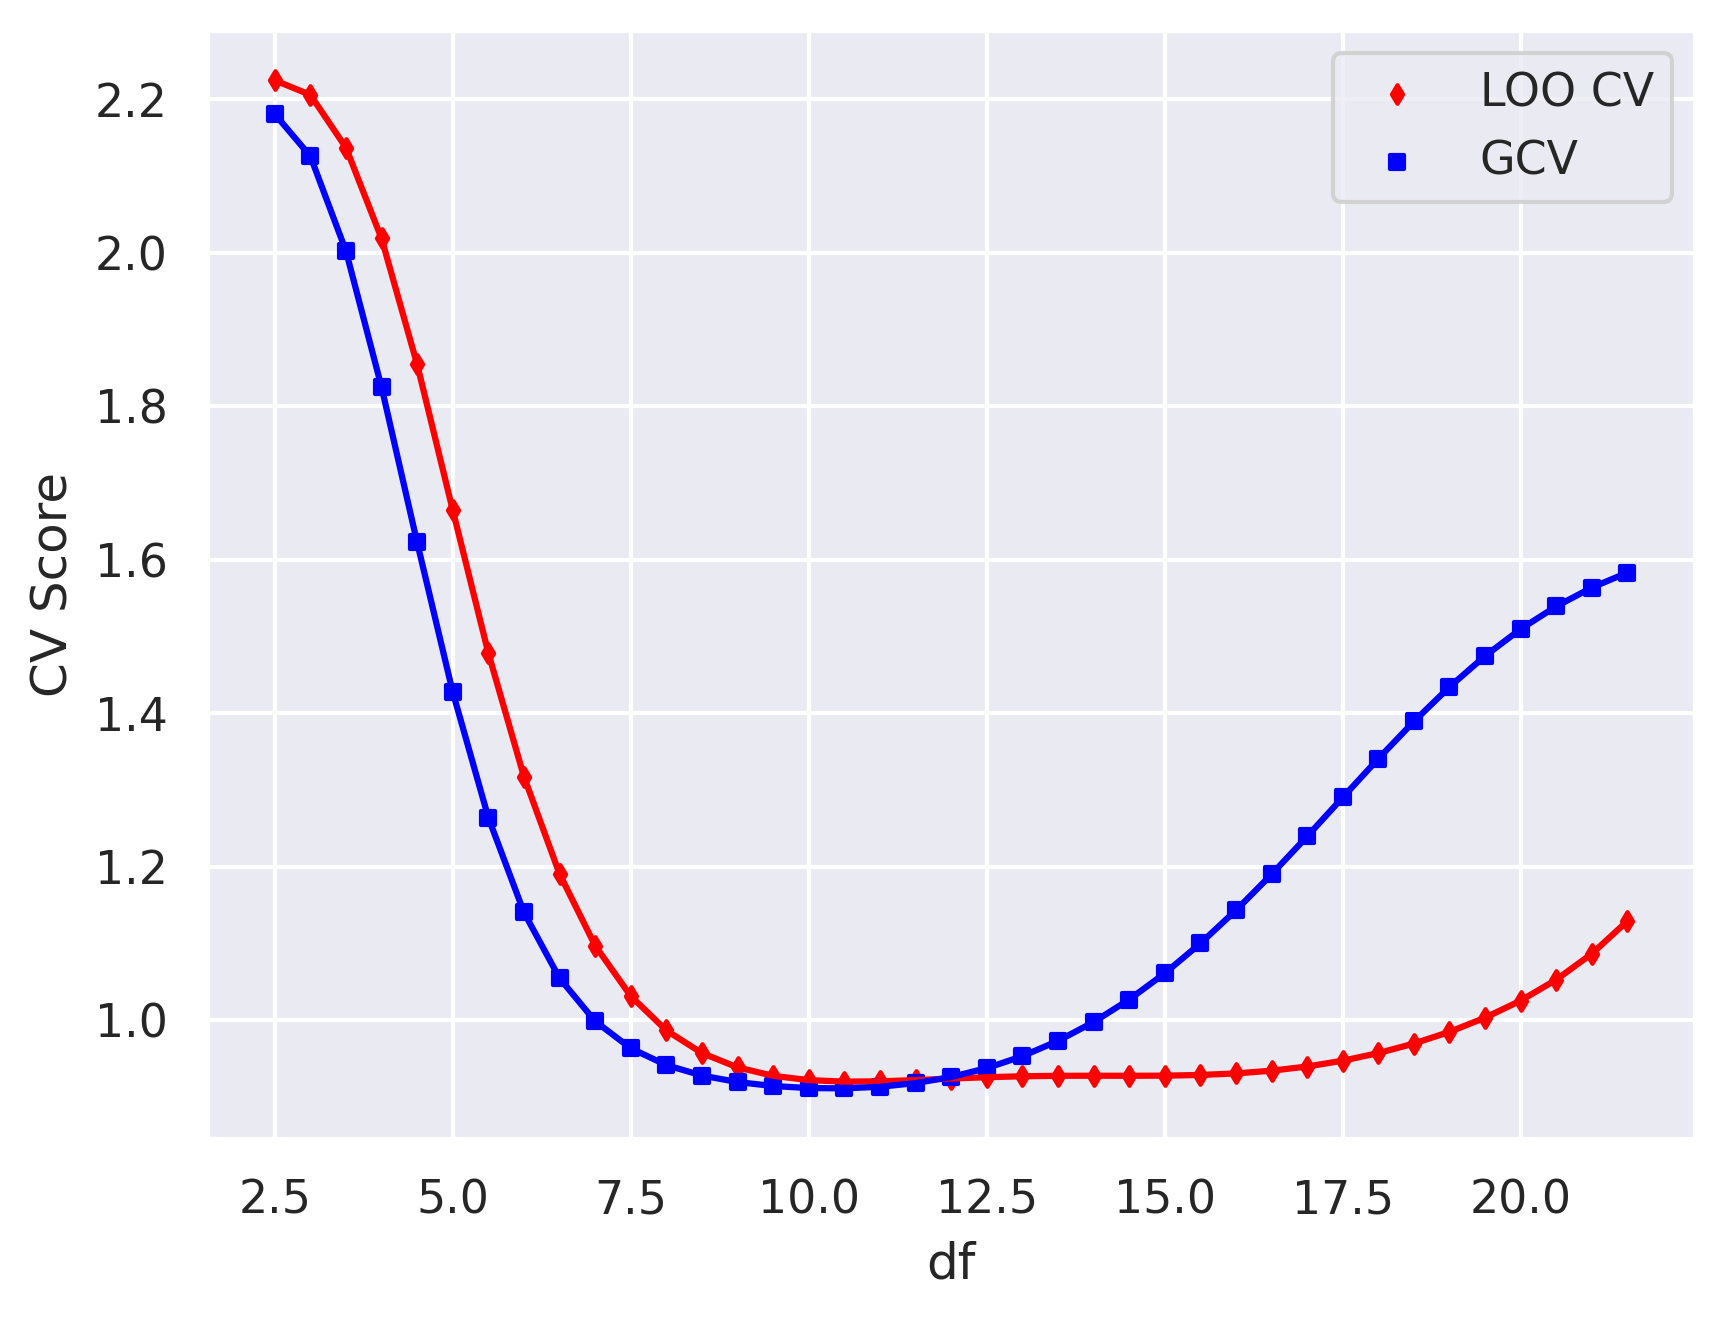

In [13]:
dfs = 2+np.arange(1, 40)/2
m = len(dfs)
my_lcv = np.zeros(m)
my_gcv = np.zeros(m)
for i in range(m):
    df = dfs[i]
    my_gcv[i] = gcv(x, y, df)
    my_lcv[i] = lcv(x, y, df)
plt.plot(dfs, my_lcv, color='red')
plt.scatter(dfs, my_lcv, color='red', marker='d', s=10, label='LOO CV')
plt.plot(dfs, my_gcv, color='blue')
plt.scatter(dfs, my_gcv, color='blue', marker='s', s=10, label='GCV')
plt.legend()
plt.xlabel("df")
plt.ylabel("CV Score")

In [14]:
opt_df = dfs[np.argmin(my_gcv)]
print(opt_df)

10.5


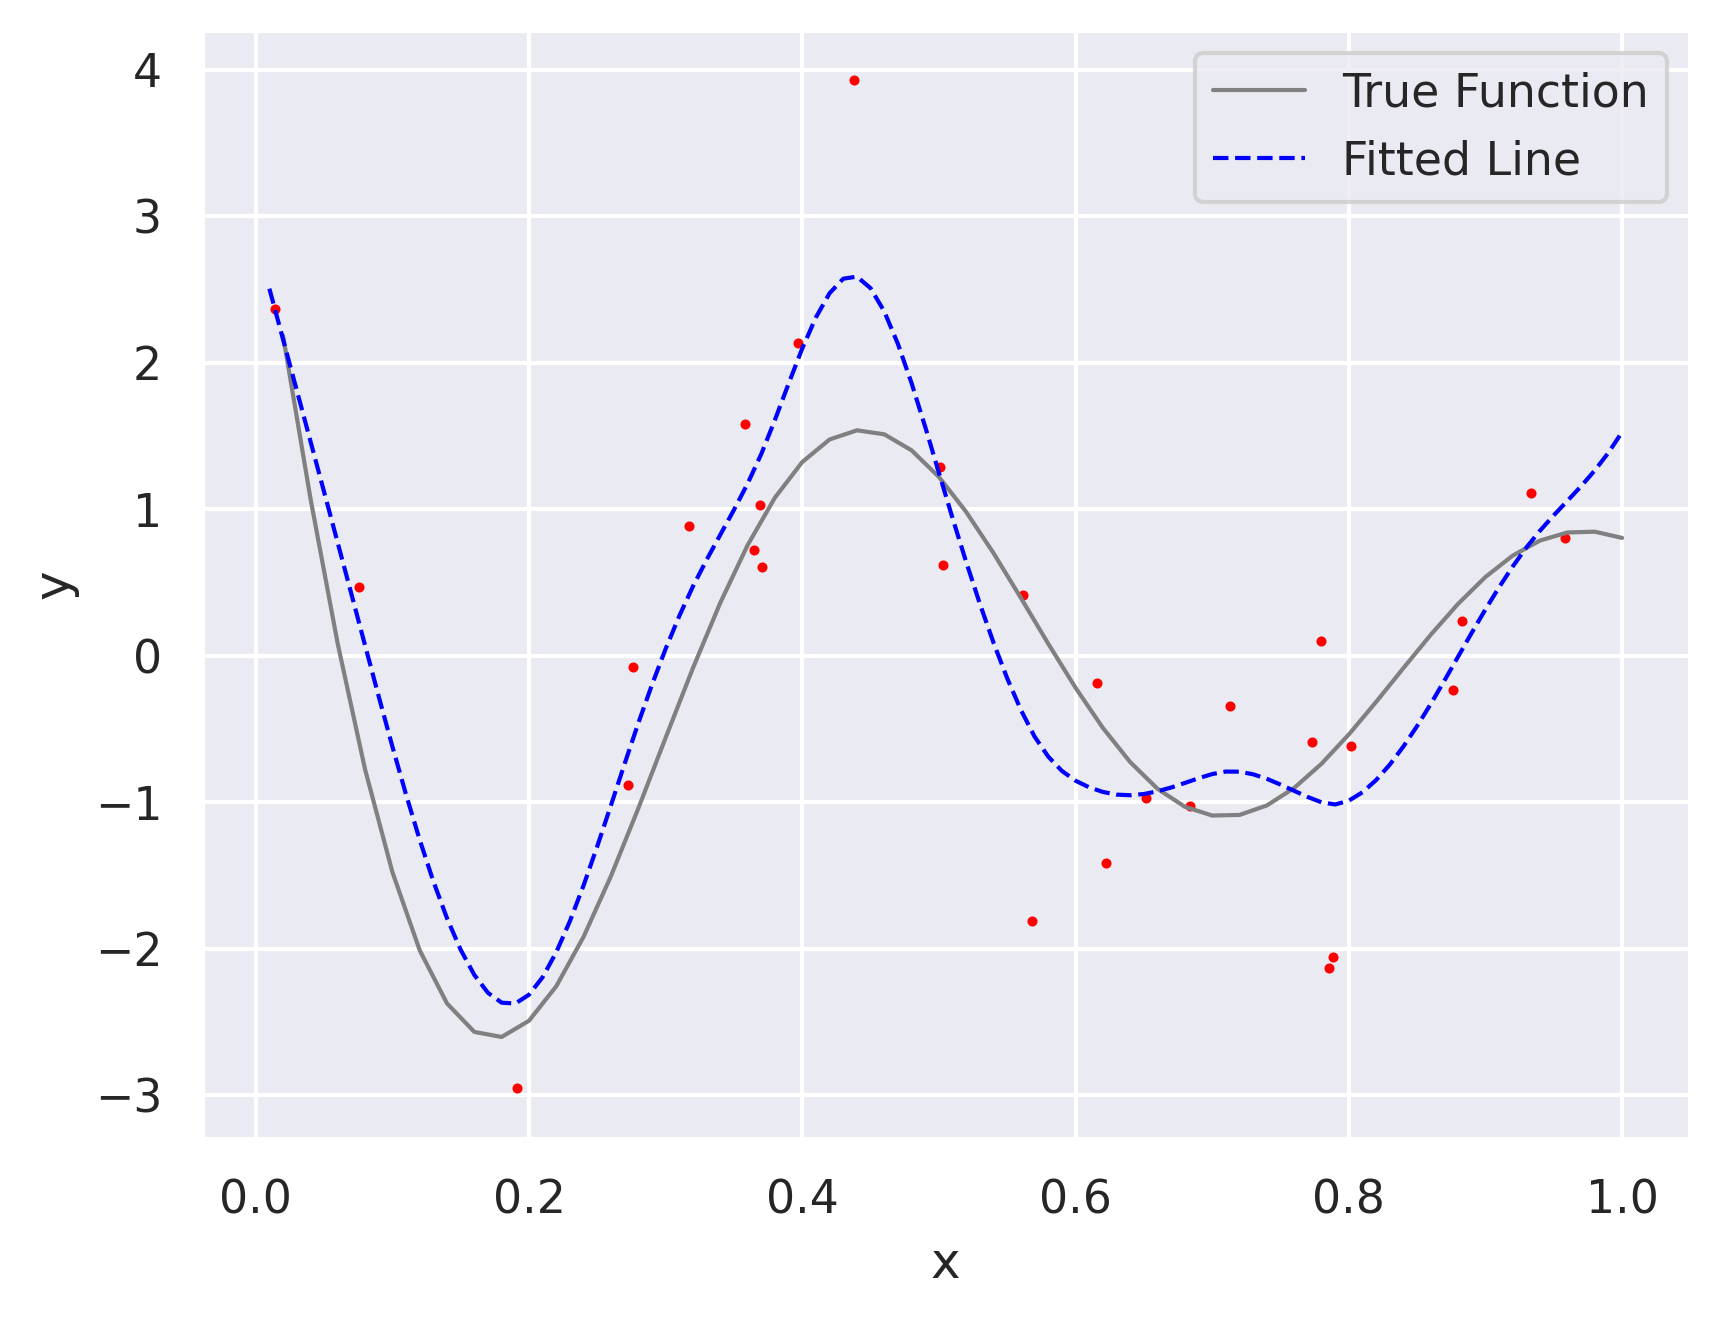

In [15]:
plt.scatter(x, y, color="red", s=2)
plt.plot(fx, fy, color="gray", linewidth=1, label="True Function")
plt.plot(np.arange(1, 101)/100, smooth_df(x, y, np.arange(1, 101)/100, opt_df), color="blue",
         linestyle="dashed", linewidth=1, label="Fitted Line")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()